In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from imutils import paths
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os

In [2]:
datasetPath='.\kvasir-dataset'
categories=[
    'dyed-lifted-polyps', 
    'dyed-resection-margins',
    'esophagitis',
    'normal-cecum',
    'normal-pylorus',
    'normal-z-line',
    'polyps',
    'ulcerative-colitis'
]
EPOCHS = 25
Learing_Rate = 1e-3
Batch_Size = 128

In [3]:
def buildModel(width, height, depth, classes):
    model = Sequential()
    inputShape = (height, width, depth)
    if backend.image_data_format() == "channels_first":
        inputShape = (depth, height, width)
    # CONV => RELU => POOL layers
    model.add(Conv2D(16, (5, 5), padding="same",input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    # CONV => RELU => POOL layers
    model.add(Conv2D(32, (5, 5), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    # CONV => RELU => POOL layers
    model.add(Conv2D(64, (5, 5), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    # FC => RELU layers
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation("relu"))
    # softmax classifier
    model.add(Dense(classes))
    model.add(Activation("softmax"))
    return model

In [4]:
def buildModel2(width, height, depth, classes):
    model = Sequential()
    inputShape = (height, width, depth)
    if backend.image_data_format() == "channels_first":
        inputShape = (depth, height, width)
    # CONV => RELU => POOL layers
    model.add(Conv2D(16, (5, 5), padding="same",input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    # CONV => RELU => POOL layers
    model.add(Conv2D(32, (5, 5), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    # CONV => RELU => POOL layers
    model.add(Conv2D(64, (5, 5), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    # CONV => RELU => POOL layers
    model.add(Conv2D(128, (5, 5), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    # FC => RELU layers
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation("relu"))
    # softmax classifier
    model.add(Dense(classes))
    model.add(Activation("softmax"))
    return model

In [5]:
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    if iteration == total: 
        print()

In [6]:
data = []
labels = []

print("[INFO] loading images...")
imagePaths = sorted(list(paths.list_images(datasetPath)))
random.seed(42)
random.shuffle(imagePaths)

printProgressBar(0, len(imagePaths), prefix = 'Progress:', suffix = 'Complete', length = 50)
for i,imagePath in enumerate(imagePaths):
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (96, 96))
    image = img_to_array(image)
    data.append(image)
    label = imagePath.split(os.path.sep)[-2]
    label = categories.index(label)
    labels.append(label)
    printProgressBar(i + 1, len(imagePaths), prefix = 'Progress:', suffix = 'Complete', length = 50)

print("[INFO] loading images completed...")

[INFO] loading images...
Progress: |██████████████████████████████████████████████████| 100.0% Complete
[INFO] loading images completed...


In [7]:
# plt.imshow(data[1])
# print(labels[1])
# print(data[1])

In [8]:
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.25, random_state=42)

trainY = to_categorical(trainY, num_classes=8)
testY = to_categorical(testY, num_classes=8)

In [9]:
# plt.imshow(trainX[0])
# print(trainY[0])
# print(trainX[0])
print ("number of training examples = " + str(trainX.shape[0]))
print ("number of test examples = " + str(testX.shape[0]))
print ("X_train shape: " + str(trainX.shape))
print ("Y_train shape: " + str(trainY.shape))
print ("X_test shape: " + str(testX.shape))
print ("Y_test shape: " + str(testY.shape))

number of training examples = 3000
number of test examples = 1000
X_train shape: (3000, 96, 96, 3)
Y_train shape: (3000, 8)
X_test shape: (1000, 96, 96, 3)
Y_test shape: (1000, 8)


In [10]:
generator = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")

In [11]:
class myCallback(Callback):
        def on_epoch_end(self, epoch, logs={}):
            if(logs.get('accuracy')>0.99):
                    print("\n[INFO] Reached 99% accuracy so cancelling training!")
                    self.model.stop_training = True
# tb_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [12]:
print("[INFO] compiling model...")
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = buildModel(width=96, height=96, depth=3, classes=8)
    model.summary()

[INFO] compiling model...
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 16)        1216      
_________________________________________________________________
activation (Activation)      (None, 96, 96, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        12832     
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0    

In [13]:
opt = Adam(lr=Learing_Rate, decay=Learing_Rate / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [14]:
# print("[INFO] training network...")
callbacks=[myCallback()]
history = model.fit(
    x=generator.flow(trainX, trainY, batch_size=Batch_Size),
    validation_data=(testX, testY), 
    steps_per_epoch=len(trainX) // Batch_Size,
    epochs=EPOCHS, 
    verbose=1)
print("[INFO] training network completed...")

Epoch 1/25
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
23/23 [==============================] - 35s 2s/step - loss: 0.3511 - accuracy: 0.2152 - val_loss: 0.2637 - val_accuracy: 0.4440
Epoch 2/25
23/23 [==============================] - 36s 2s/step - loss: 0.2311 - accuracy: 0.5198 - val_loss: 0.1980 - val_accuracy: 0.6080
Epoch 3/25
23/23 [==============================] - 34s 1s/step - loss: 0.2030 - accuracy: 0.5742 - val_loss: 0.1895 - val_accuracy: 0.6340
Epoch 4/25
23/23 [==============================] - 34s 1s/step - loss: 0.1930 - accuracy: 0.5898 - val_loss: 0.1875 - val_accuracy: 0.6060
Epoch 5/25
23/23 [==============================] - 35s 2s/step - loss: 0.1893 - accuracy: 0.5992 - val_loss: 0.1852 - val_accuracy: 0.6220
Epoch 6/25
23/23 [==============================] - 33s 1s/step - loss: 0.1869 - accuracy: 0.6083 - val_loss: 0.2104 - val_accuracy: 0.5610
Epoch 7/25
23/23 [==============================] - 35s 2s/step - loss: 0.1794

In [15]:
print("[INFO] saving model...")
model.save('Model3.model', save_format="h5")
print("[INFO] model saved")

[INFO] saving model...
[INFO] model saved


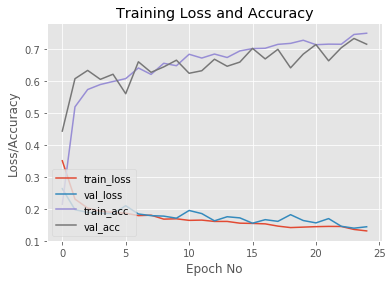

In [16]:
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch No")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()
# plt.savefig('plot.png')

In [19]:
history.history["accuracy"]

[0.21518105268478394,
 0.5198467969894409,
 0.5741643309593201,
 0.5898328423500061,
 0.5992339849472046,
 0.6082869172096252,
 0.6416440010070801,
 0.6215181350708008,
 0.6563370227813721,
 0.648676872253418,
 0.6845403909683228,
 0.6727019548416138,
 0.6852367520332336,
 0.6744428873062134,
 0.6949860453605652,
 0.7022980451583862,
 0.703342616558075,
 0.7155292630195618,
 0.7186629772186279,
 0.7284122705459595,
 0.714484691619873,
 0.7162256240844727,
 0.7158774137496948,
 0.7465181350708008,
 0.7503482103347778]